In [3]:
from numpy import *
from matplotlib.pyplot import *
import sys; sys.path.insert(0,'/home/noah/Desktop/large_analysis/ca_analysis/');import os
import fileread as fr
import predefined as pd
from scipy.signal import fftconvolve
from scipy.optimize import curve_fit
import pickle
import time

def gauss(t,mu=0,sigma=1):
    return (2*3.14159*sigma**2.)**(-0.5)*exp(-(t-t[mu])**2./(2.*sigma**2.))


def fit_convolution(X,a,sigma):
    print('Made it')
    hist,bins,fitLength,mu=X
#     print(a,sigma)
    return a*fftconvolve(hist,gauss(bins,mu=mu,sigma=sigma))[mu:mu+fitLength]

In [2]:
loc='/home/noah/Desktop/large_analysis/zeck_simulation/snbpdip/'
sim=load(loc+'113Sn.npy')
# sim=fr.simulation(loc+'113Sn.txt')
sim=sim.view(recarray)
sim=sim[pd.sim_single_event(sim)]
sim=pd.sim_restructure(sim).view(np.recarray)

FileNotFoundError: [Errno 2] No such file or directory: '/home/noah/Desktop/large_analysis/zeck_simulation/snbpdip/113Sn.npy'

In [54]:
from importlib import reload; reload(pd)
loc='/home/noah/Desktop/large_analysis/ca_analysis/cur_data/calib_src_runs/'
runs=[run for run in os.listdir(loc) if run.endswith('-all.dat') and int(run[4:-8]) < 133]
data=[]
for run in runs:
    data.append(pd.precuts(fr.gen_output(loc+run)[0]))
data=np.hstack(data).view(recarray)
data.energy=pd.vec_calibrate(data.energy,data.board,data.channel)

# Fitting detector response function parameter $\sigma$ for each pixel

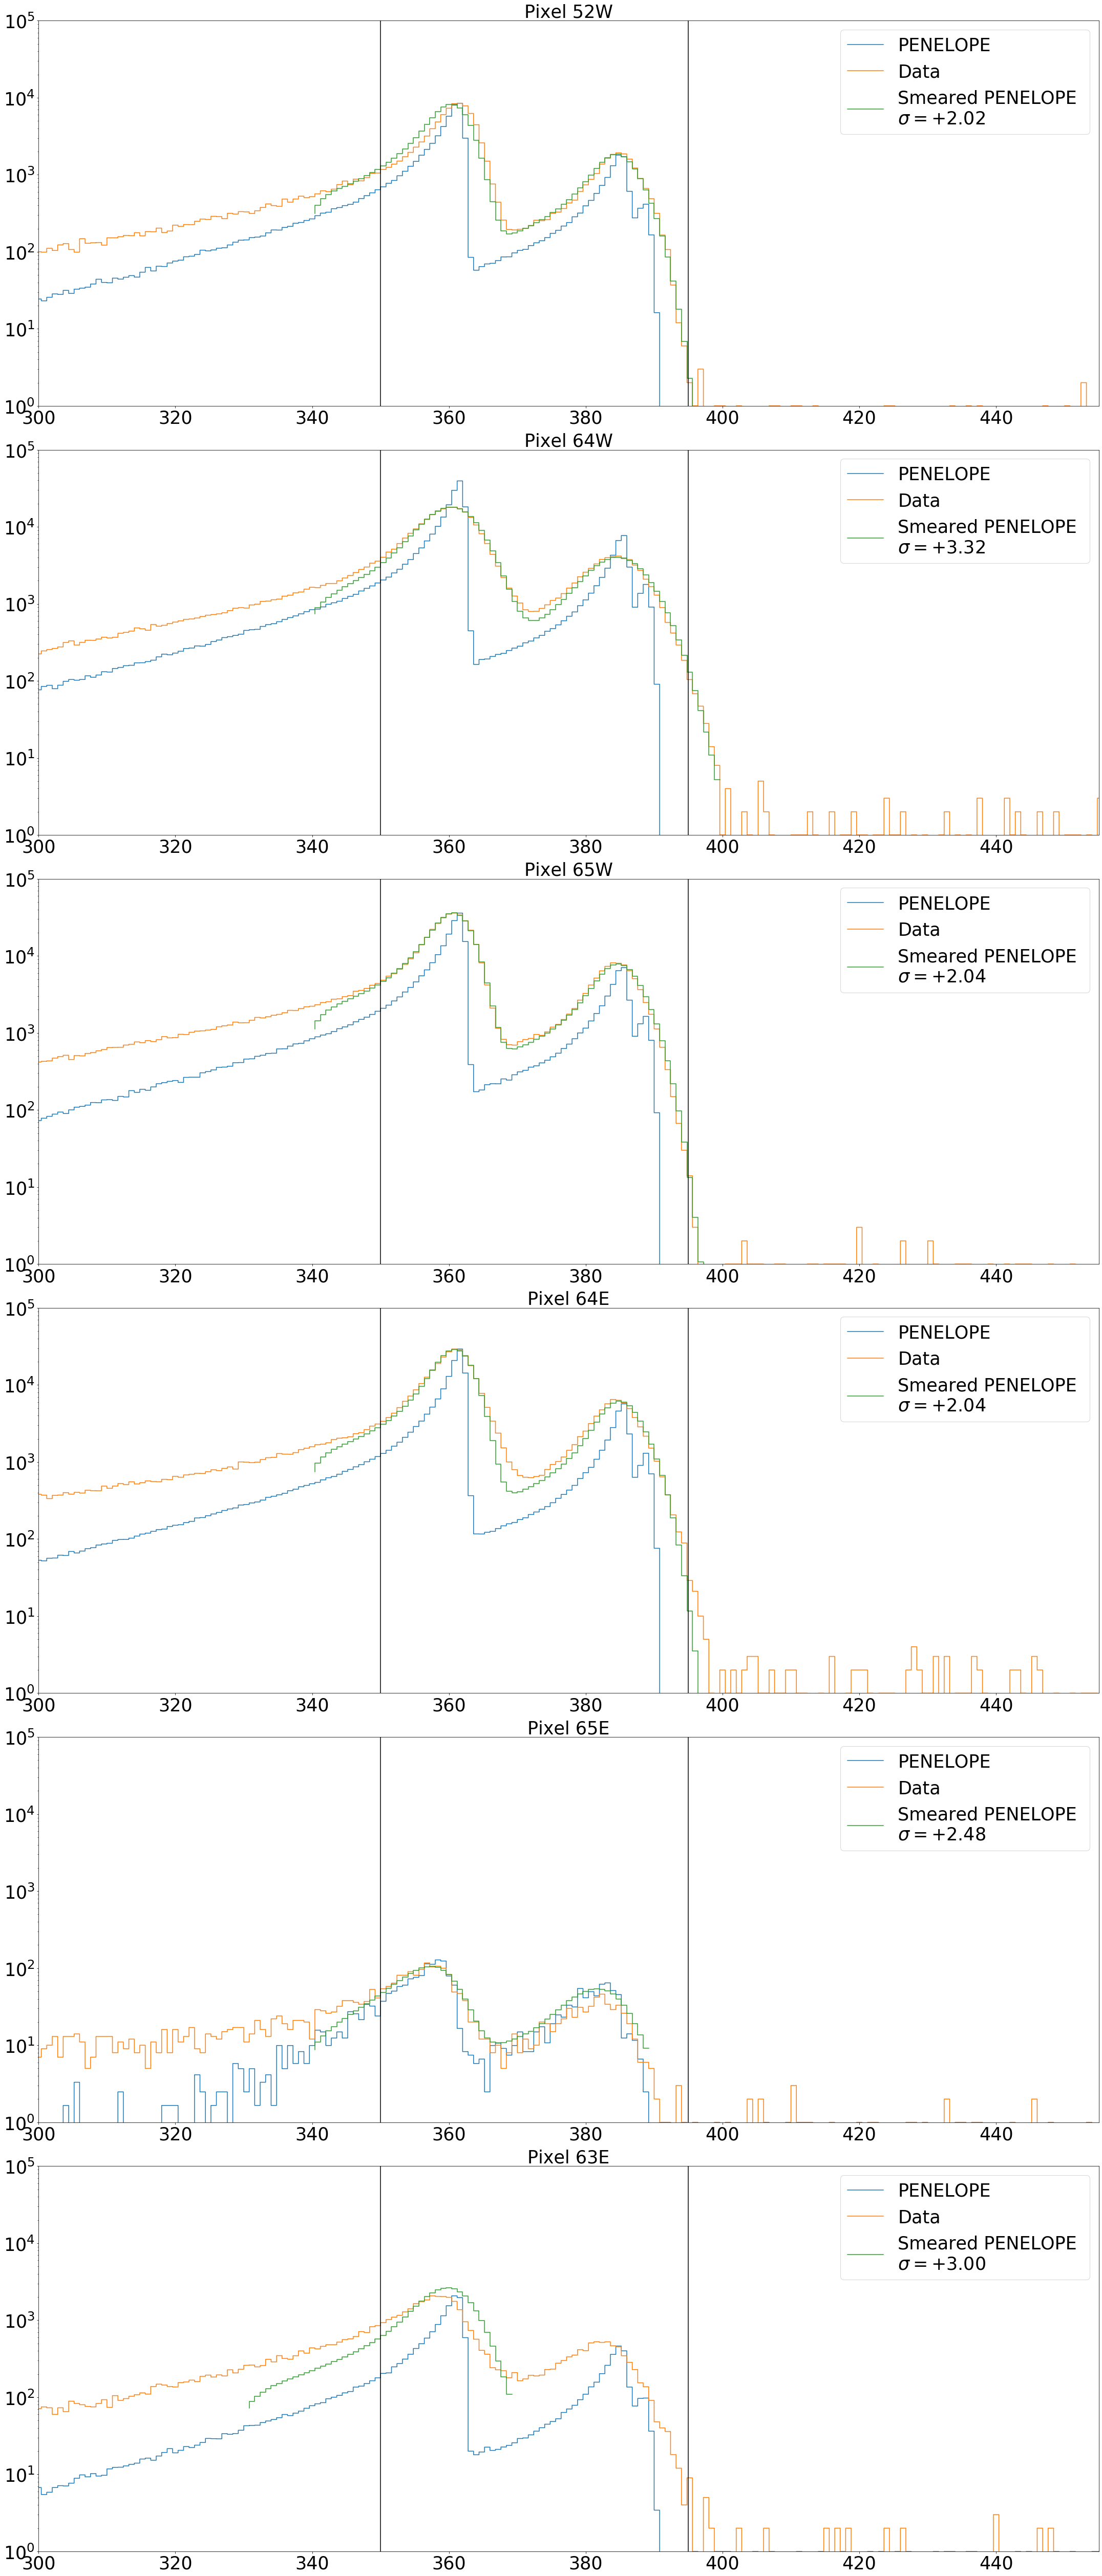

In [58]:
from importlib import reload
reload(pd)
fs=35
mu=400
pixels=zeros(6,dtype=[('pixel','i4'),('detector','U1')])
pixels['pixel']=64,64,65,52,65,63
pixels['detector']='E','W','W','W','E','E'
pixels=pixels.view(recarray)

bdchs=[6,11,12,35,36,34]
# detector_response=np.zeros(5,dtype=[('pixel',int),('detector','U1'),('sigma',float)])
# detector_response=detector_response.view(recarray)
dr={}

fig,ax=subplots(nrows=len(pixels),ncols=1,figsize=(30,10+int(10*len(pixels))))
for i,bdch in enumerate(bdchs):
    bd,ch=divmod(bdch,8)
    t=(sim.board==bd)*(sim.channel==ch)
#     detector_response.pixel[i]=p.pixel
#     detector_response.detector[i]=p.detector

    s,b=histogram(sim.energy[t],bins=1000,range=[0,800])
    t=(data.board==bd)*(data.channel==ch)
    d,b=histogram(data.energy[t],bins=1000,range=[0,800])
    b=pd.cbins(b)
#     print(pd.pixel(bd,ch),np.sum(d[b>300]))
    s,d=s.astype(float),d.astype(float)
    s=s/amax(s)*amax(d[b>50])

    beg,end=340,400
    if bdch==36:
        end=390
    if bdch== 34:
        beg=330
        end=370
    trutharray = (b>beg)*(b<end)
    fitbins=b[trutharray]
    simhist=s[trutharray]
    fithist=d[trutharray]

    
    X=simhist

    sigma=fithist**0.5
    sigma[sigma==0]=1
    sigma=1./sigma
    
    fitLength=len(fitbins)
    fit_convolution = lambda hist,a,sigma:a*fftconvolve(hist,gauss(b,mu=mu,sigma=sigma))[mu:mu+fitLength]
    
    if pd.pixel(bd,ch)==63:
        pars,vrs=curve_fit(fit_convolution,xdata=X,ydata=fithist,\
                           p0=[1.,0.5],epsfcn=1e-4,sigma=sigma,\
                          check_finite=False)
    else:
        pars,vrs=curve_fit(fit_convolution,xdata=X,ydata=fithist,\
                           p0=[1.,1],epsfcn=1e-4,sigma=sigma,\
                          check_finite=False)
#     if bdch==34:
#         pars[1]=3
#     detector_response.sigma[i]=pars[1]
    dr.update({8*bd+ch:pars[1]})
    # hist,bins,fitSize,mu=X;a,sigma=2.5,3
    # c1=a*fftconvolve(hist,gauss(bins,mu=mu,sigma=sigma))[mu:mu+fitSize]
    # print(pars)
    c1=fit_convolution(X,*pars)
    ax[i].set_title('Pixel '+pd.pixel(bd,ch), fontsize=fs)
    ax[i].plot(b,s,ds='steps',label='PENELOPE')
    ax[i].plot(b,d,ds='steps',label='Data')
    # plot(b,2.5*c[mu:mu+len(b)],ds='steps',label='Smeared PENELOPE')
    ax[i].plot(fitbins,c1,ds='steps',\
         label='Smeared PENELOPE \n'+r'$\sigma=$+''{:0.2f}'.format(pars[1]))

    ax[i].tick_params(labelsize=fs)
    ax[i].axvline(350,color='k')
    ax[i].axvline(395,color='k')
    ax[i].set_yscale('log')
    ax[i].legend(fontsize=fs)
    ax[i].set_xlim(300,455)
    ax[i].set_ylim(1,1e5)
#     if bdch==12:
#         ax[i].set_ylim(1,1e6)
    if bdch==33:
        ax[i].set_ylim(1,1e3)
tight_layout()
savefig('fits_to_relev_pixels')
show()
with open('detector_response.pickle','wb') as f:
    pickle.dump(dr,f)
# save('detector_response',detector_response)

# Testing the gaussian smearing (parameter input by hand)

In [18]:
fs=11

trutharray=(sim.detector=='W')*(sim.pixel==65)

s,b=histogram(sim.energy,bins=1000,range=[0,800])
d,b=histogram(data.energy,bins=1000,range=[0,800])
b=pd.cbins(b)
s,d=s.astype(float),d.astype(float)
s=s/amax(s)*amax(d[b>50])

trutharray = (b>320)*(b<450)
fitbins=b[trutharray]
fithist=d[trutharray]

sigma=3
mu=200
beg,end=len(b[b<mu]),len(b)+len(b[b <mu])
c=fftconvolve(s,gauss(b,mu=mu,sigma=sigma),mode='full')
sigma=0.1
c1=fftconvolve(fithist,gauss(b,mu=mu,sigma=sigma),mode='full')
print(c1.shape,c.shape)

figure(figsize=(10,7))
plot(b,s,ds='steps',label='PENELOPE')
plot(b,d,ds='steps',label='Data')
plot(b,2.5*c[mu:mu+len(b)],ds='steps',label='Smeared PENELOPE')
plot(fitbins,0.3*c1[mu:mu+len(fitbins)],ds='steps',label='Smeared PENELOPE')

tick_params(labelsize=fs)
axvline(350,color='k')
axvline(395,color='k')
yscale('log')
legend(fontsize=fs)
xlim(300,455)
ylim(1,2e4)
show()

AttributeError: recarray has no attribute detector